# Прогнозирование фактической выработки электроэнергии
Имеется датасет с именем "test_data.csv". В нём расположены данные по работе электростанции, а именно:
* timestamp_hour_end - время события;
* PBR - плановый график работы по заданию Системного оператора, МВтч;
* power - фактическая выработка электроэнергии, МВтч;
* pressure_msl -атмосферное давление, , измеряемая в единицах давления земной атмосферы на уровне моря (1013 гектопаскалей)
* relativehumidity_2m - относительная влажность на уровне 2м от уровня земли, %;
* temperature_2m -температура атмосферного воздуха на уровне 2м от уровня земли, град цельсия;
* winddirection_10m - направление ветра на уровне 10м от уровня земли, градусы;
* windspeed_10m - скорость ветра на уровне 10м от уровня земли, м/с.

Необходимо спрогнозировать целевой признак "power"  2 суток вперёд (+48 часов).

## Загрузка данных

In [1]:
!pip install shap -q
!pip install scikit-learn --upgrade -q
!pip install seaborn --upgrade -q
!pip install missingno -q
!pip install catboost -q
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error
import shap

In [2]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

Загрузим и ознакомимся с данными.

In [3]:
df = pd.read_csv('test_data.csv', sep=',')
shape_1 = df.shape[0]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39023 entries, 0 to 39022
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp_hour_end   39023 non-null  object 
 1   PBR                  39023 non-null  float64
 2   power                37943 non-null  float64
 3   pressure_msl         38210 non-null  float64
 4   relativehumidity_2m  38210 non-null  float64
 5   temperature_2m       38210 non-null  float64
 6   winddirection_10m    38210 non-null  float64
 7   windspeed_10m        38210 non-null  float64
dtypes: float64(7), object(1)
memory usage: 2.4+ MB


,timestamp_hour_end,PBR,power,pressure_msl,relativehumidity_2m,temperature_2m,winddirection_10m,windspeed_10m
0,2019-01-01 01:00:00,1185.0,1186.56,1028.1,89.0,-8.8,304.0,1.3
1,2019-01-01 02:00:00,1185.0,1184.64,1028.4,90.0,-8.9,304.0,2.6
2,2019-01-01 03:00:00,1185.0,1186.20,1028.3,89.0,-8.9,294.0,4.3
3,2019-01-01 04:00:00,1185.0,1185.96,1028.1,91.0,-9.3,283.0,3.3
4,2019-01-01 05:00:00,1185.0,1184.16,1027.9,91.0,-9.6,285.0,5.6


Видно, что в датафрейме имеются пропуски.

## Предобработка данных

### Дубликаты

В датафрейме столбец "timestamp_hour_end" по сути является уникальным идентификатором строки, проверить на явные дубликаты нужно по этому столбцу, т.к. данные в других столбцах могут повторяться.

In [4]:
df['timestamp_hour_end'].duplicated().sum()

0

Явные дубликаты отсутствуют, помимо этого неявных дубликатов также нет. 

### Пропуски

Оценим структуру пропусков.

<Axes: >

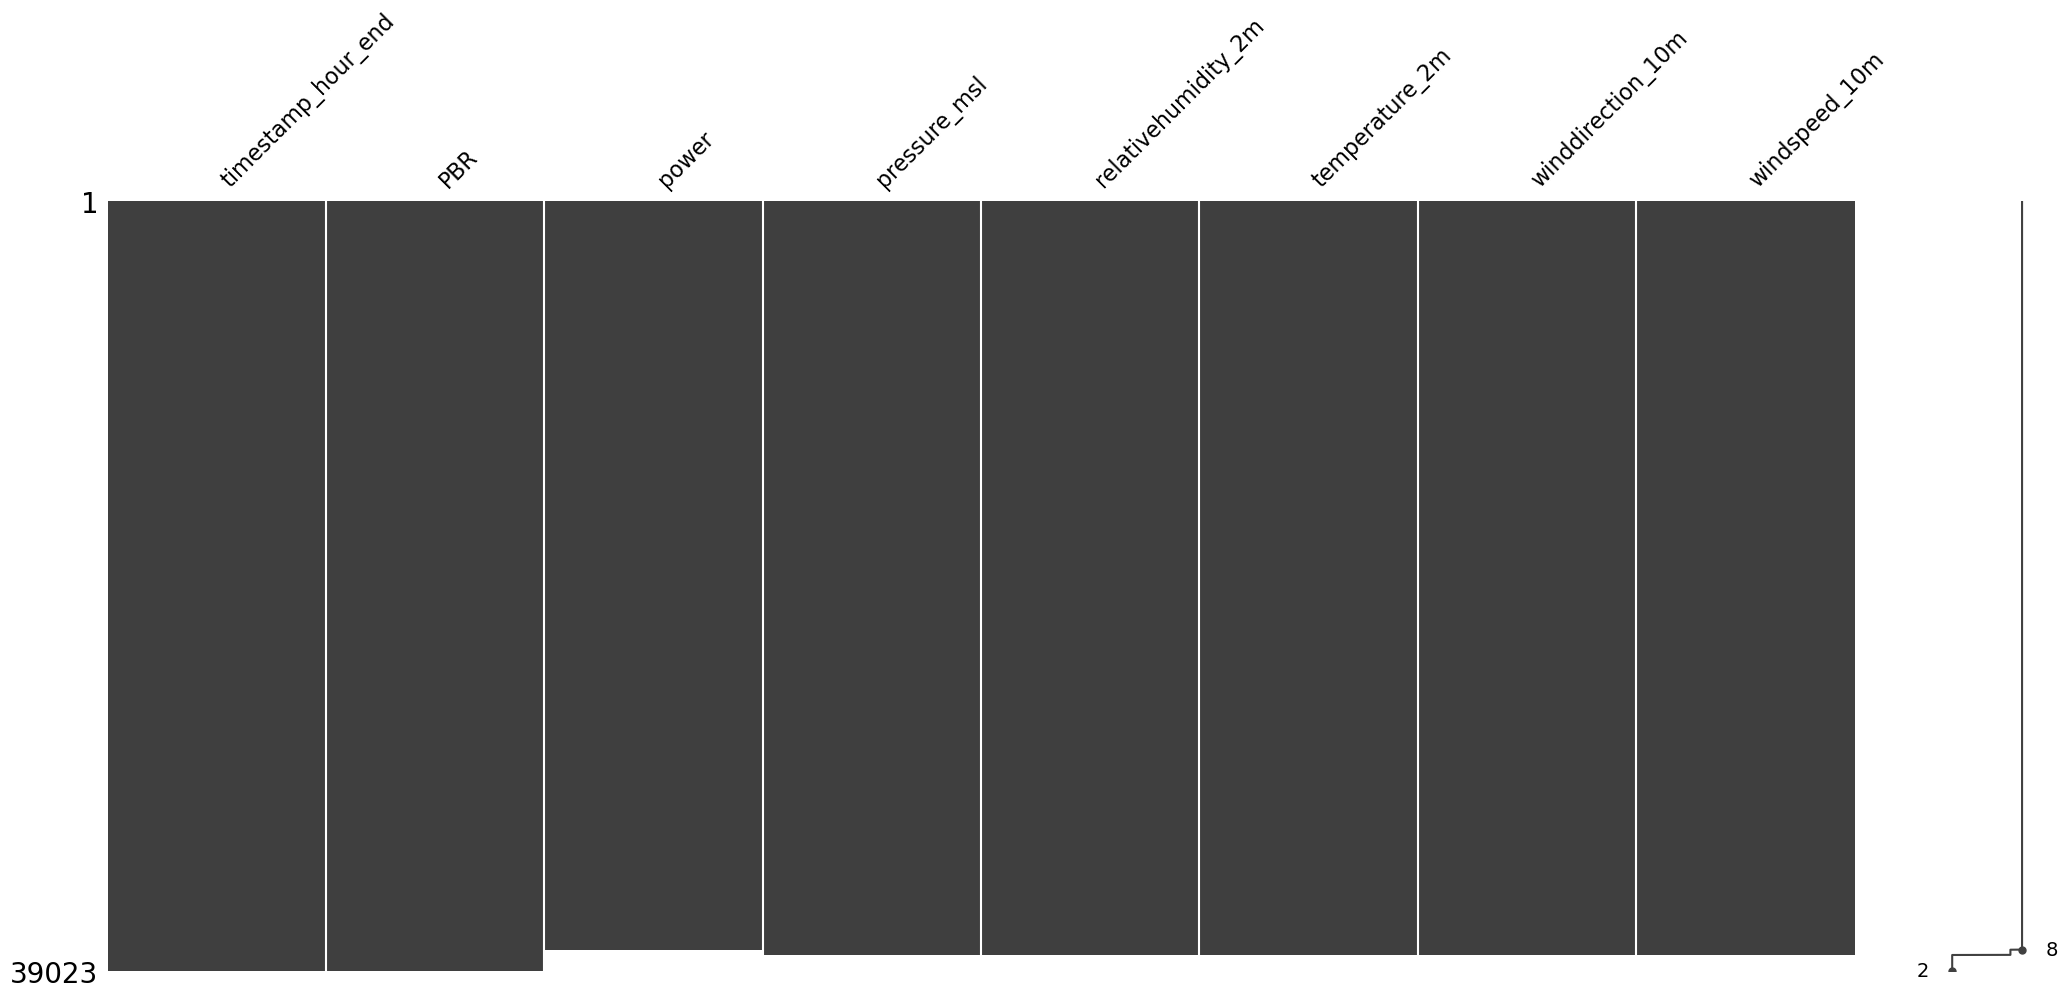

In [5]:
msno.matrix(df)

Видно, что пропуски находятся в конце датафрейма, их можно удалить.

In [6]:
df = df[:37943]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37943 entries, 0 to 37942
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp_hour_end   37943 non-null  object 
 1   PBR                  37943 non-null  float64
 2   power                37943 non-null  float64
 3   pressure_msl         37943 non-null  float64
 4   relativehumidity_2m  37943 non-null  float64
 5   temperature_2m       37943 non-null  float64
 6   winddirection_10m    37943 non-null  float64
 7   windspeed_10m        37943 non-null  float64
dtypes: float64(7), object(1)
memory usage: 2.3+ MB


In [7]:
round(df.shape[0] / shape_1 * 100, 3)

97.232

После удаления осталось примерно 97% данных, что вполне приемлемо для дальнейшей работы.

###  Изменение типов данных

Изменим тип данных столбца 'timestamp_hour_end' и оценим за какой промежуток времени имеются данные.

In [8]:
df['timestamp_hour_end']  = pd.to_datetime(df['timestamp_hour_end'], format='%Y-%m-%d %H:%M:%S')
print(df['timestamp_hour_end'].min(), '-', df['timestamp_hour_end'].max())

2019-01-01 01:00:00 - 2023-04-30 23:00:00


В качестве индекса установим столбец 'timestamp_hour_end'

In [9]:
df = df.set_index('timestamp_hour_end')
df.head()

,PBR,power,pressure_msl,relativehumidity_2m,temperature_2m,winddirection_10m,windspeed_10m
timestamp_hour_end,,,,,,,
2019-01-01 01:00:00,1185.0,1186.56,1028.1,89.0,-8.8,304.0,1.3
2019-01-01 02:00:00,1185.0,1184.64,1028.4,90.0,-8.9,304.0,2.6
2019-01-01 03:00:00,1185.0,1186.20,1028.3,89.0,-8.9,294.0,4.3
2019-01-01 04:00:00,1185.0,1185.96,1028.1,91.0,-9.3,283.0,3.3
2019-01-01 05:00:00,1185.0,1184.16,1027.9,91.0,-9.6,285.0,5.6


## Исследовательский анализ данных

In [10]:
def plot(ser):
    plt.title("График параметра "+ser.name)
    plt.ylabel(ser.name)
    ser.plot(figsize=(10, 5), grid=True)
    plt.xlabel('Date')

def decompose(ser):
    
    decomposed = seasonal_decompose(ser) 

    plt.figure(figsize=(9, 8))
    plt.subplot(311)

    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.xlabel('Date')
    plt.subplot(312)

    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.xlabel('Date')
    plt.subplot(313)

    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.xlabel('Date')
    plt.tight_layout()

def season(ser, a, b):
    decomposed = seasonal_decompose(ser) 
    decomposed.seasonal[a:b].plot(ax=plt.gca(),figsize=(10, 5))
    plt.title('Seasonality')
    plt.xlabel('Date')

def box(ser):
    plt.title("Диаграмма размаха для параметра "+ser.name)
    plt.ylabel(ser.name)
    ser.plot(kind='box', figsize=(7, 10), grid=True)
    print(ser.describe())

### power

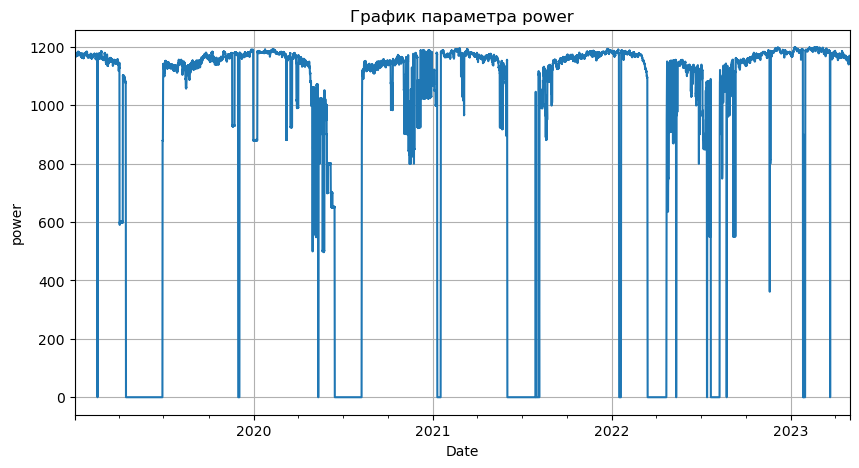

In [11]:
plot(df['power'])

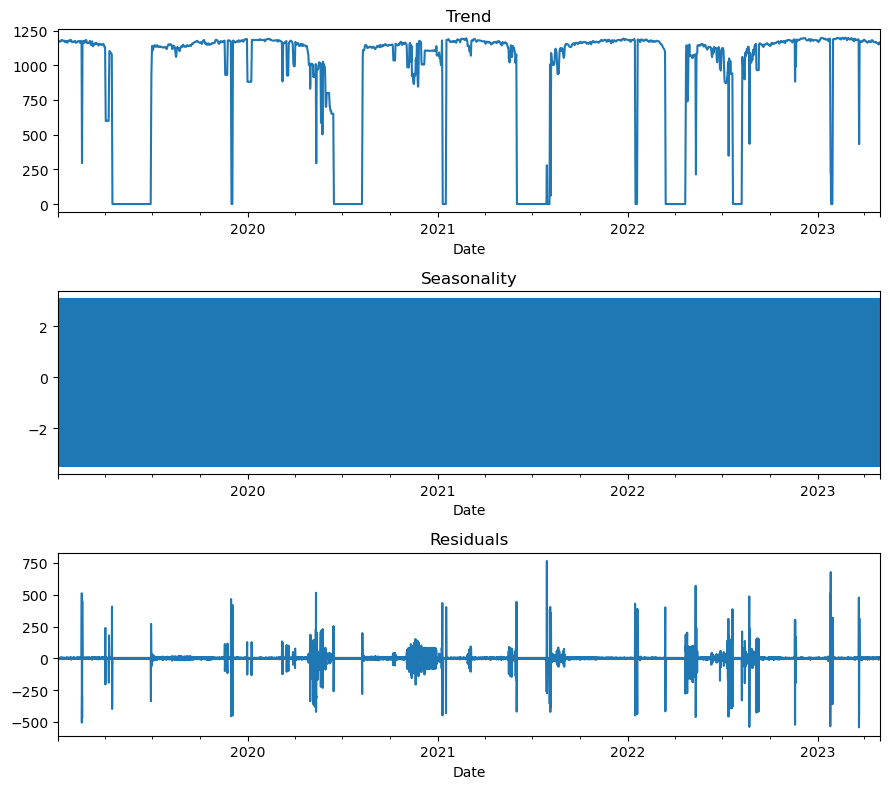

In [12]:
decompose(df['power'])

Тренд данного параметра типичен для электростанций, видны остановы на ремонт, мощность растет к зиме и падает к лету. Рассмотрим поподробнее сезонность.

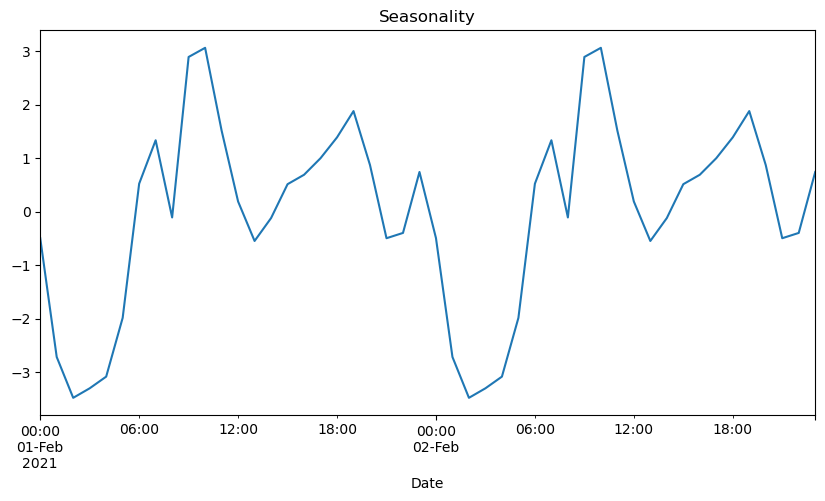

In [13]:
season(df['power'], '2021-02-01', '2021-02-02')

Видно, что имеется утренний и вечерний пики, минимум приходится примерно на 02:00.

count    37943.000000
mean       931.478499
std        435.100229
min          0.000000
25%       1006.740000
50%       1150.440000
75%       1174.080000
max       1198.920000
Name: power, dtype: float64


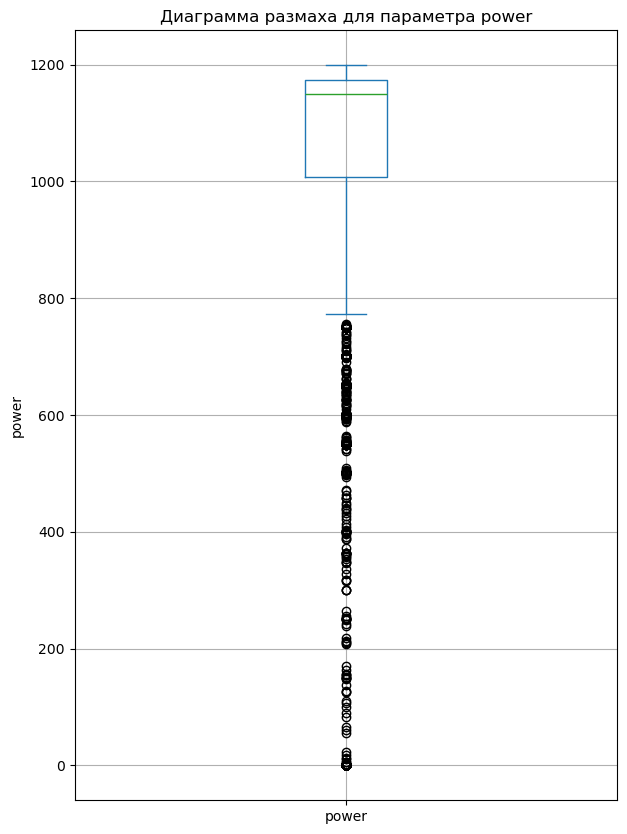

In [14]:
box(df['power'])

Чаще всего фактическая выработка электроэнергии составляет от 1006.7 до 1174.0 МВт*ч.

### PBR

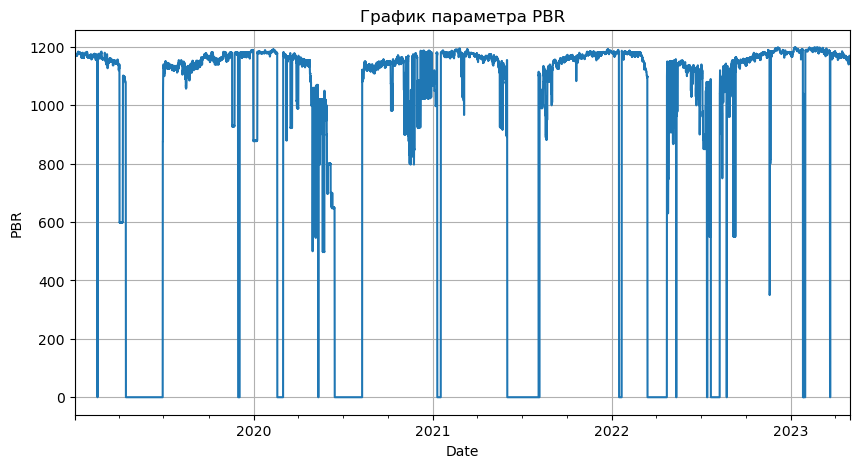

In [15]:
plot(df['PBR'])

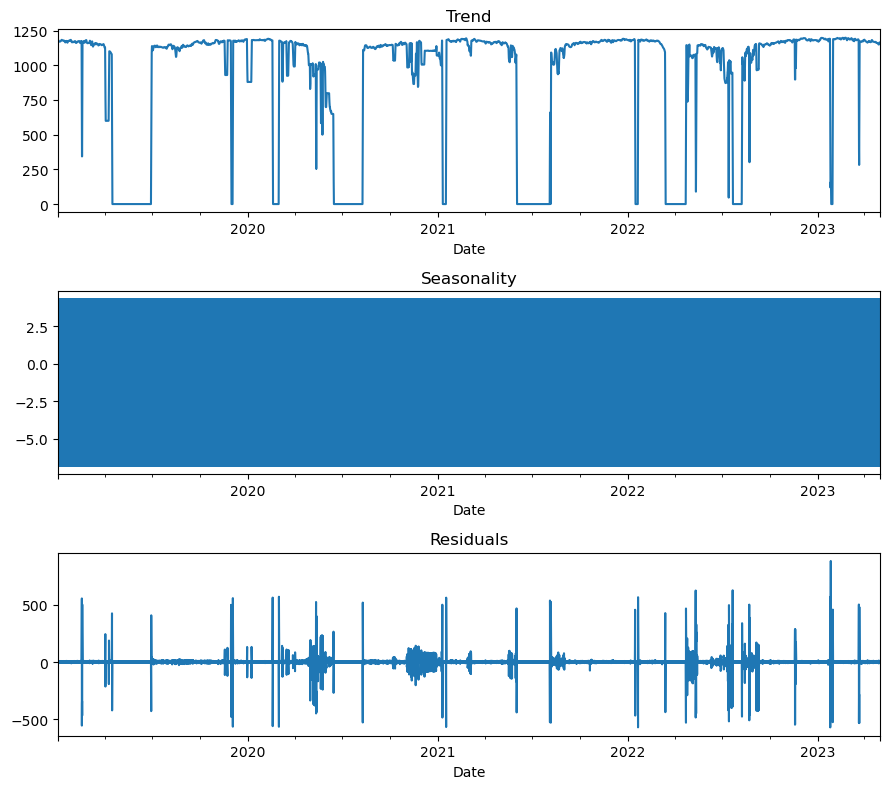

In [16]:
decompose(df['PBR'])

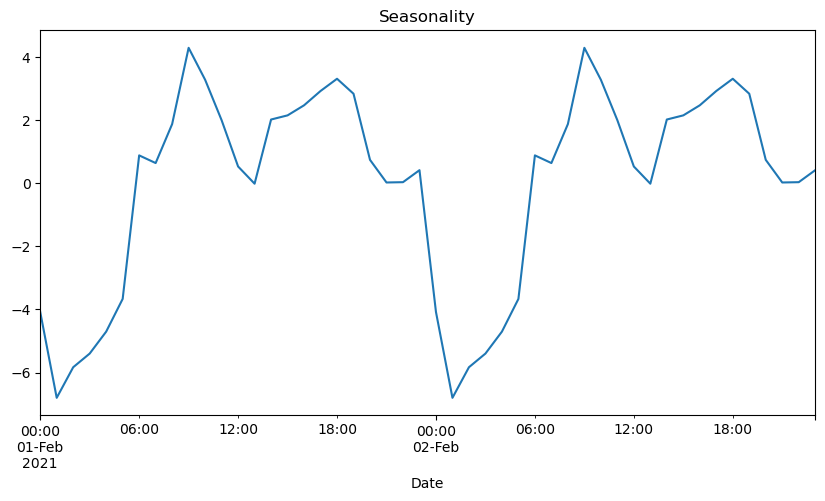

In [17]:
season(df['PBR'], '2021-02-01', '2021-02-02')

count    37943.000000
mean       918.827337
std        446.506127
min          0.000000
25%       1000.000000
50%       1150.000000
75%       1174.000000
max       1199.000000
Name: PBR, dtype: float64


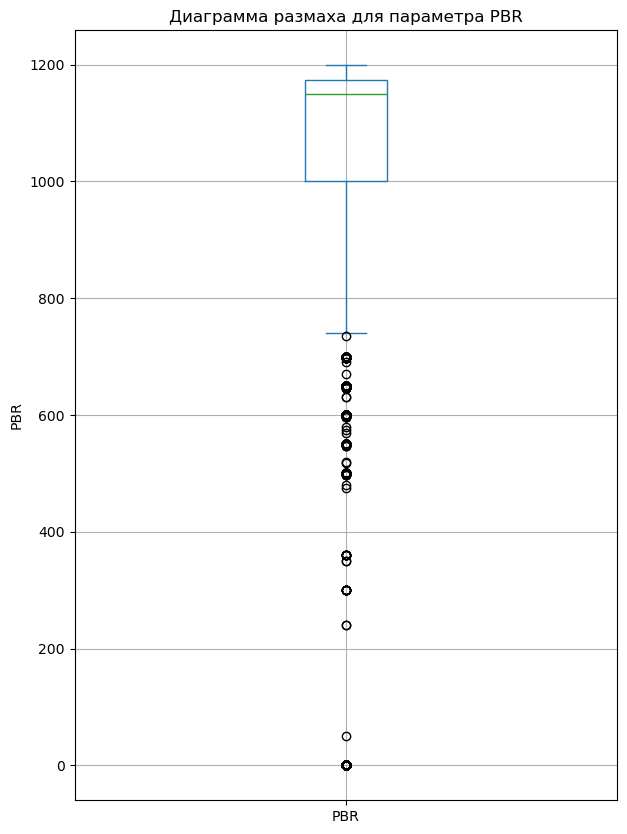

In [18]:
box(df['PBR'])

Чаще всего PBR составляет от 1000.0 до 1174.0 МВт*ч.

Видно, что данные данного столбца очень схожи с данными столбца 'power', что неудивительно.

### pressure_msl

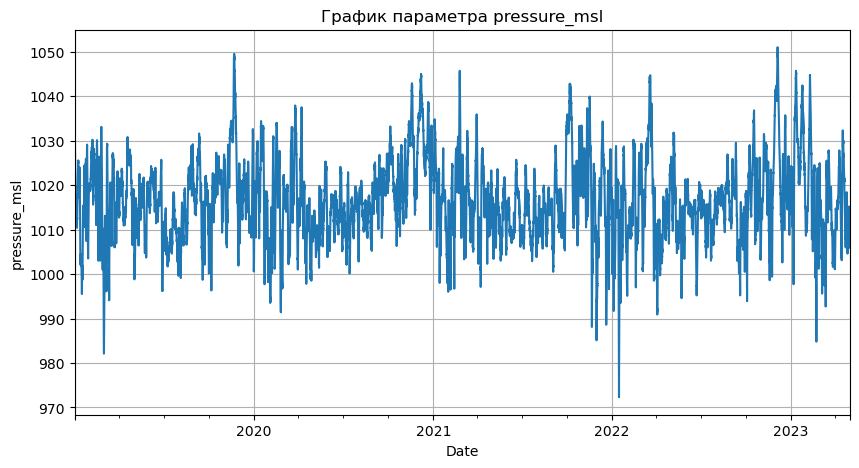

In [19]:
plot(df['pressure_msl'])

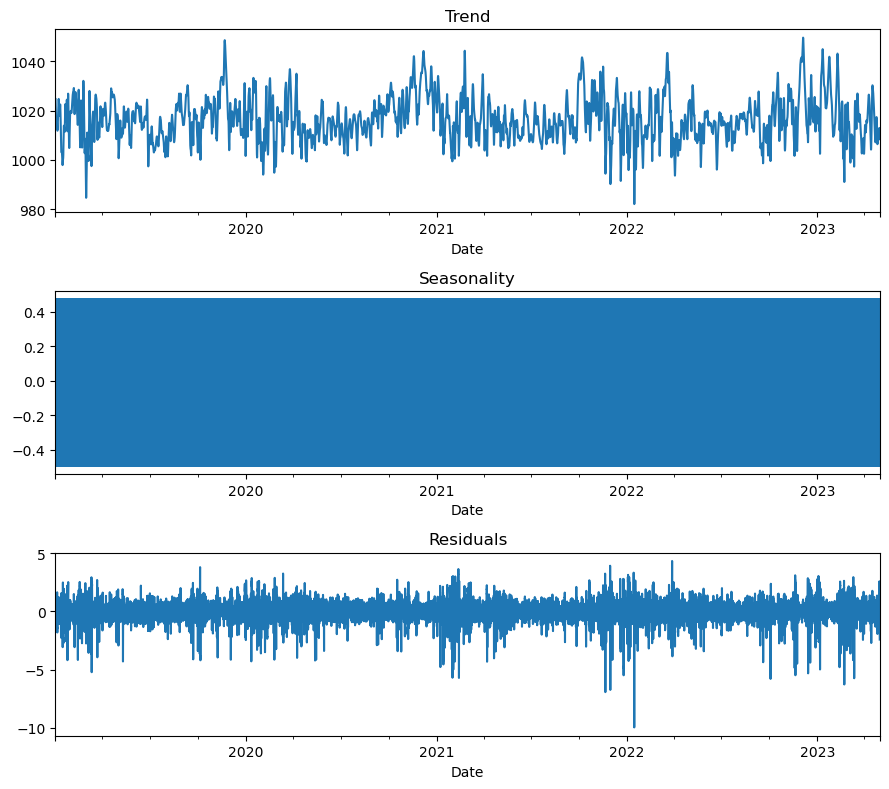

In [20]:
decompose(df['pressure_msl'])

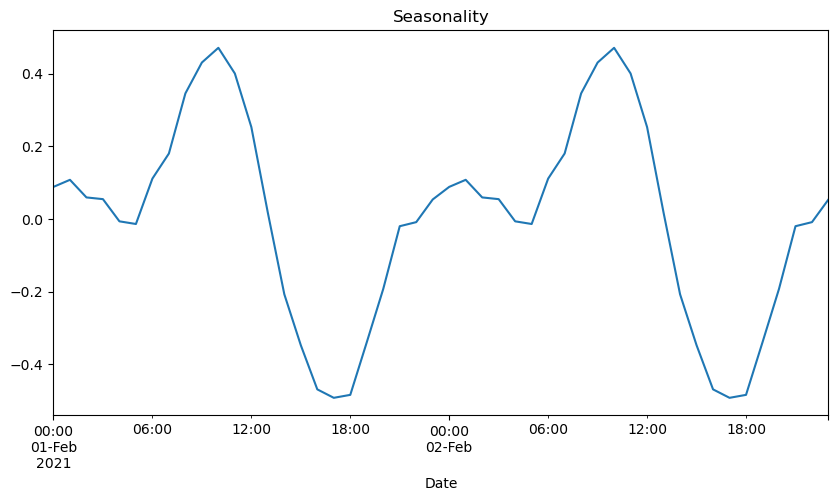

In [21]:
season(df['pressure_msl'], '2021-02-01', '2021-02-02')

Макисмум атмосферного давления приходится примерно на 11:00, минимум - 17:00.

count    37943.000000
mean      1016.627112
std          9.123638
min        972.300000
25%       1010.400000
50%       1016.000000
75%       1022.000000
max       1051.000000
Name: pressure_msl, dtype: float64


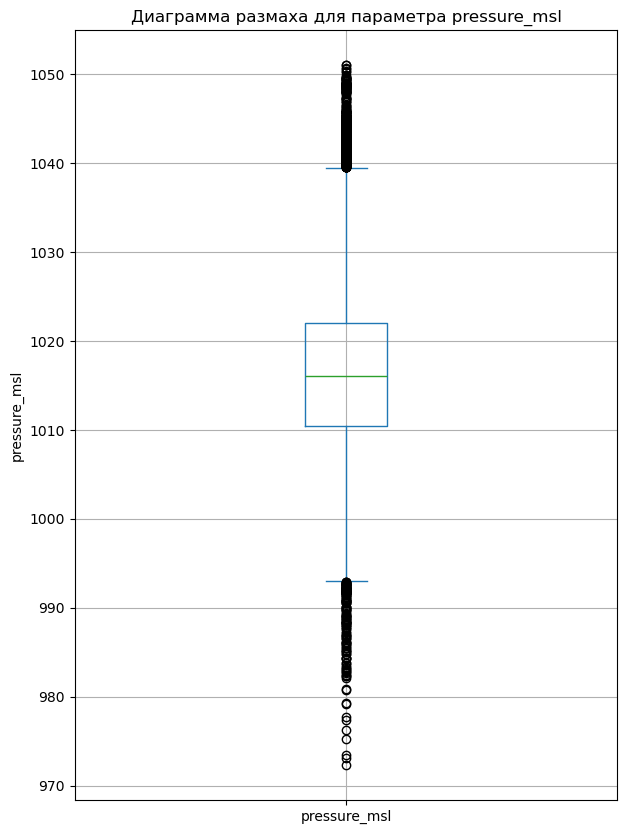

In [22]:
box(df['pressure_msl'])

Чаще всего атмосферное давление составляет от 1010.4 до 1022.0 гектопаскалей.

### relativehumidity_2m

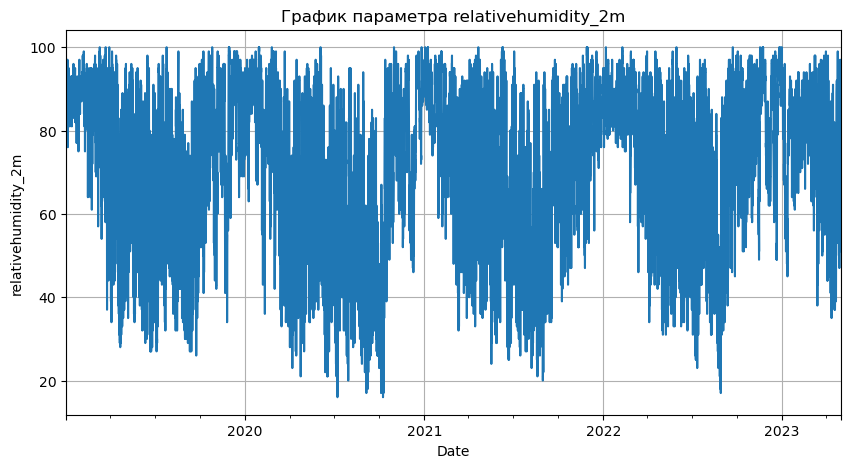

In [23]:
plot(df['relativehumidity_2m'])

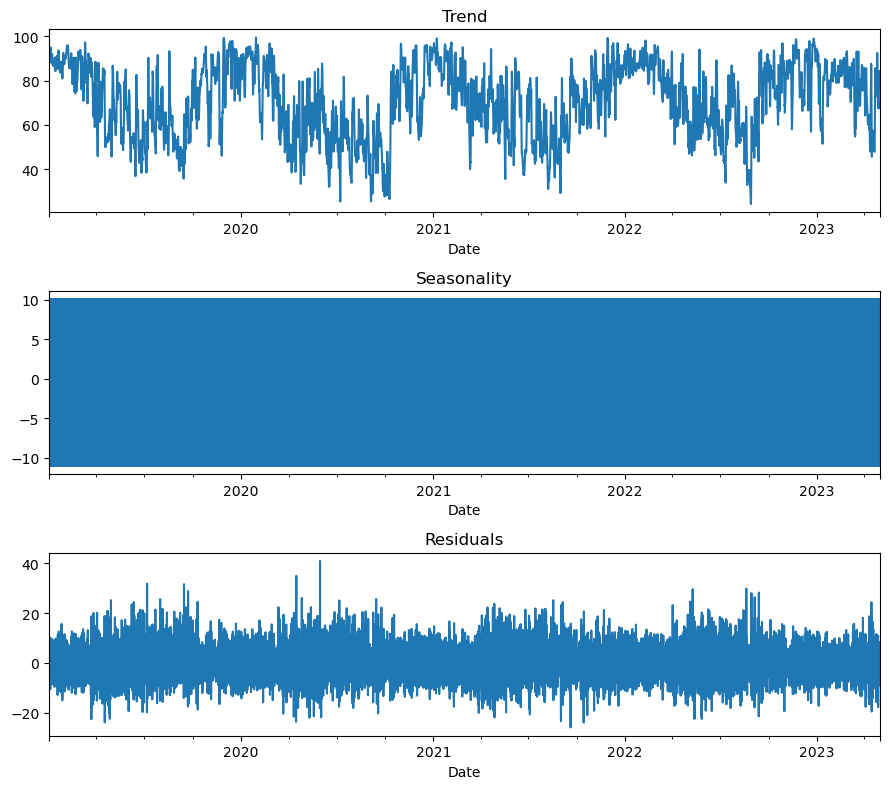

In [24]:
decompose(df['relativehumidity_2m'])

Исходя из тренда, можно понять, что на влажность влияет сезон.

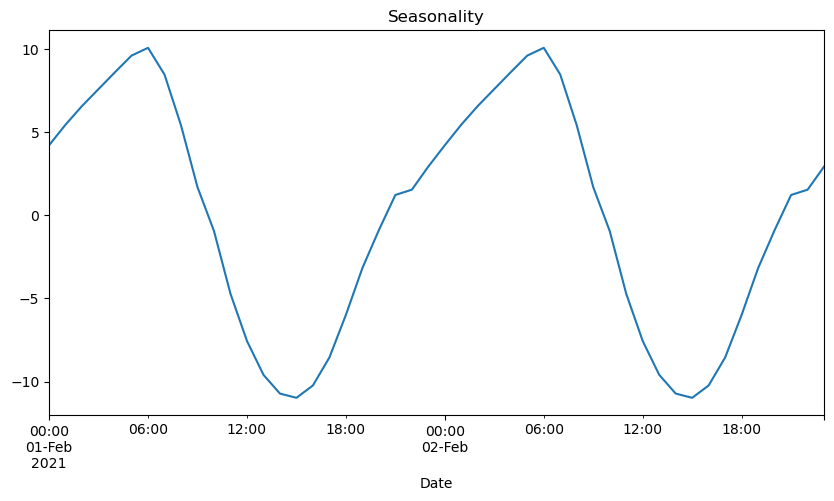

In [25]:
season(df['relativehumidity_2m'], '2021-02-01', '2021-02-02')

Максимум влажности - примерно 6:00, минимум - 15:00.

count    37943.000000
mean        70.682023
std         19.092340
min         16.000000
25%         56.000000
50%         74.000000
75%         87.000000
max        100.000000
Name: relativehumidity_2m, dtype: float64


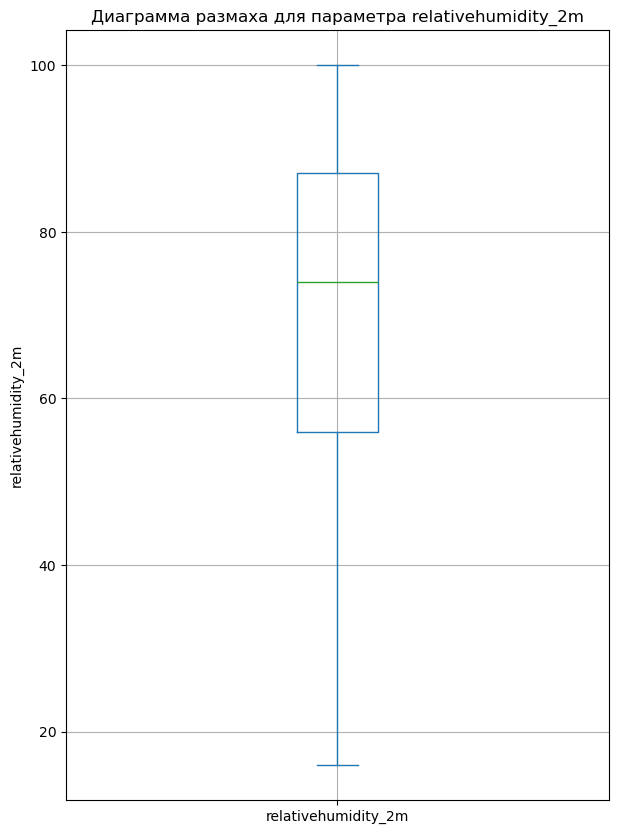

In [26]:
box(df['relativehumidity_2m'])

Чаще всего относительная влажность составляет от 56.0% до 87.0%.

### temperature_2m

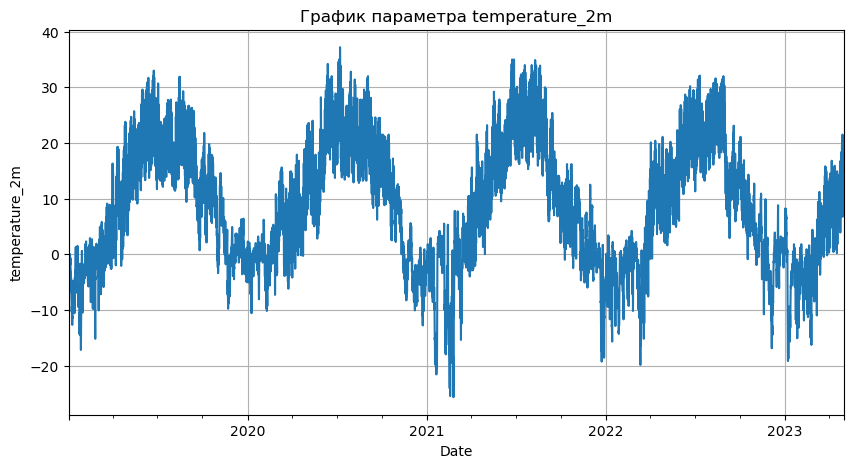

In [27]:
plot(df['temperature_2m'])

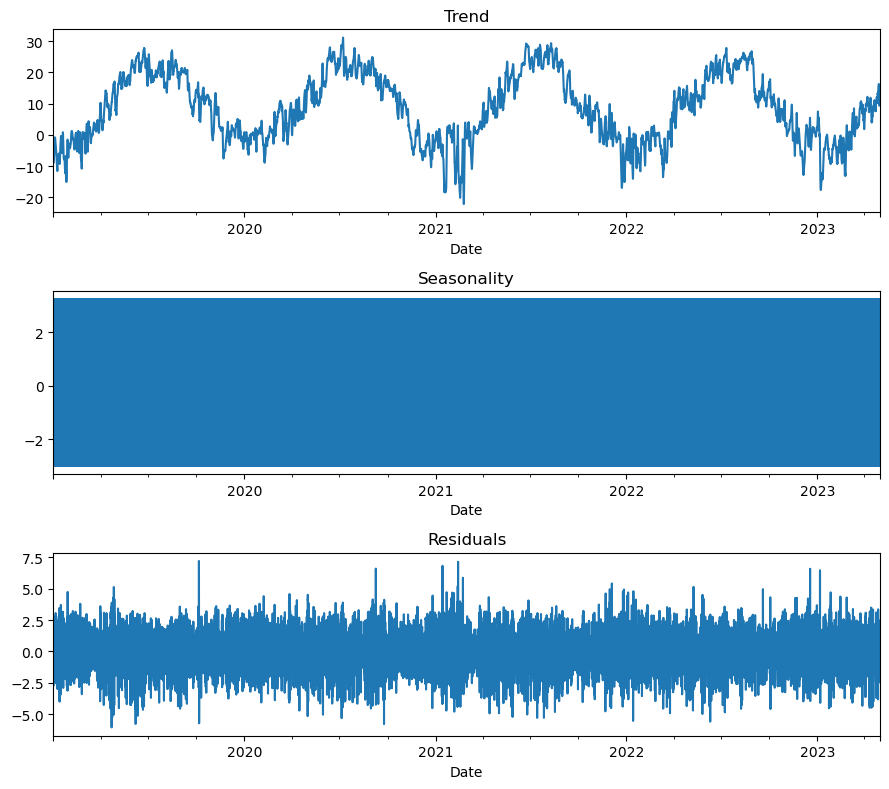

In [28]:
decompose(df['temperature_2m'])

Как и на влажность на температуру существенно влияет сезон.

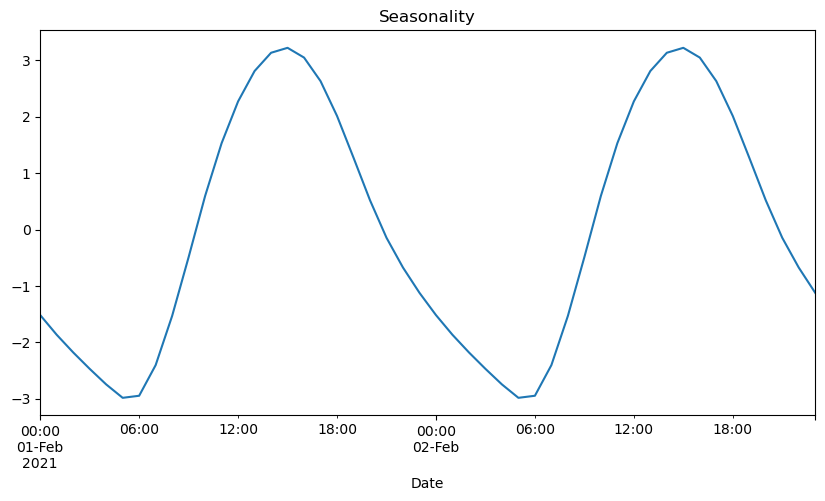

In [29]:
season(df['temperature_2m'], '2021-02-01', '2021-02-02')

Максимум температуры - 13:00, минимум - 5:00.

count    37943.000000
mean         8.474591
std         10.986589
min        -25.700000
25%          0.000000
50%          8.200000
75%         17.300000
max         37.200000
Name: temperature_2m, dtype: float64


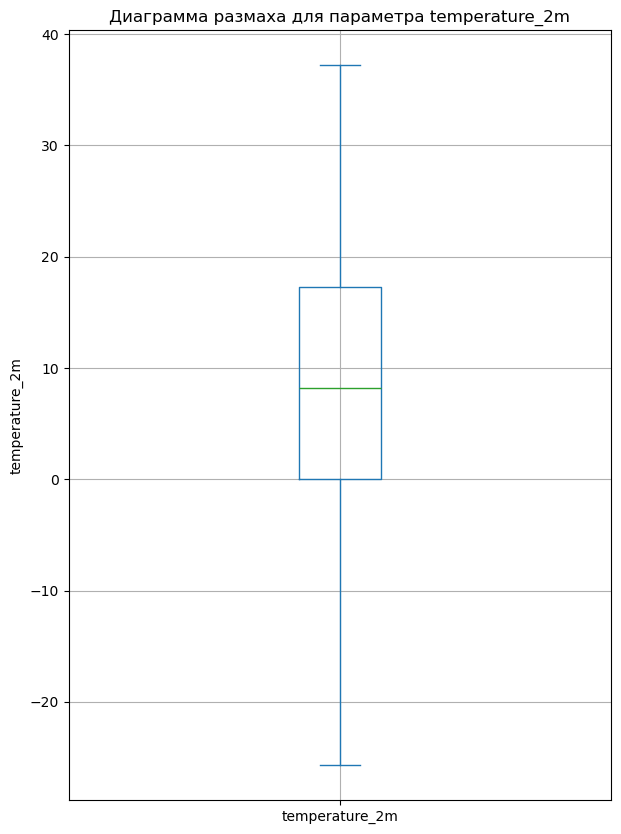

In [30]:
box(df['temperature_2m'])

Чаще всего температура составляет от -0.1 до 17.3 ℃.

### winddirection_10m

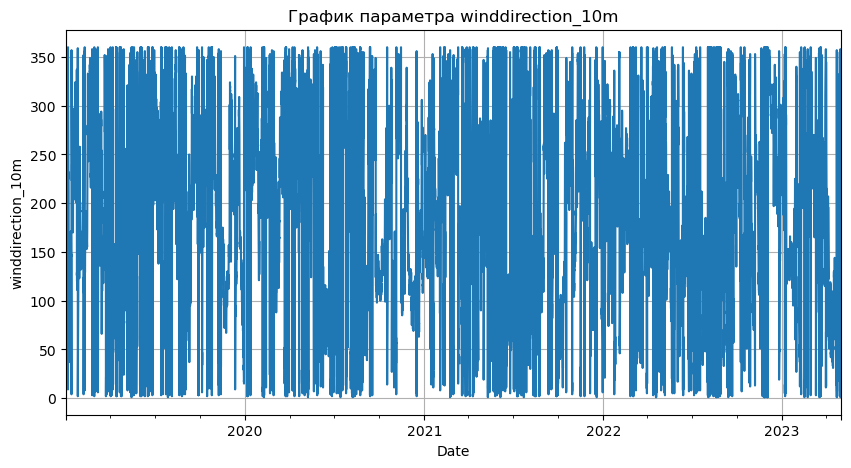

In [31]:
plot(df['winddirection_10m'])

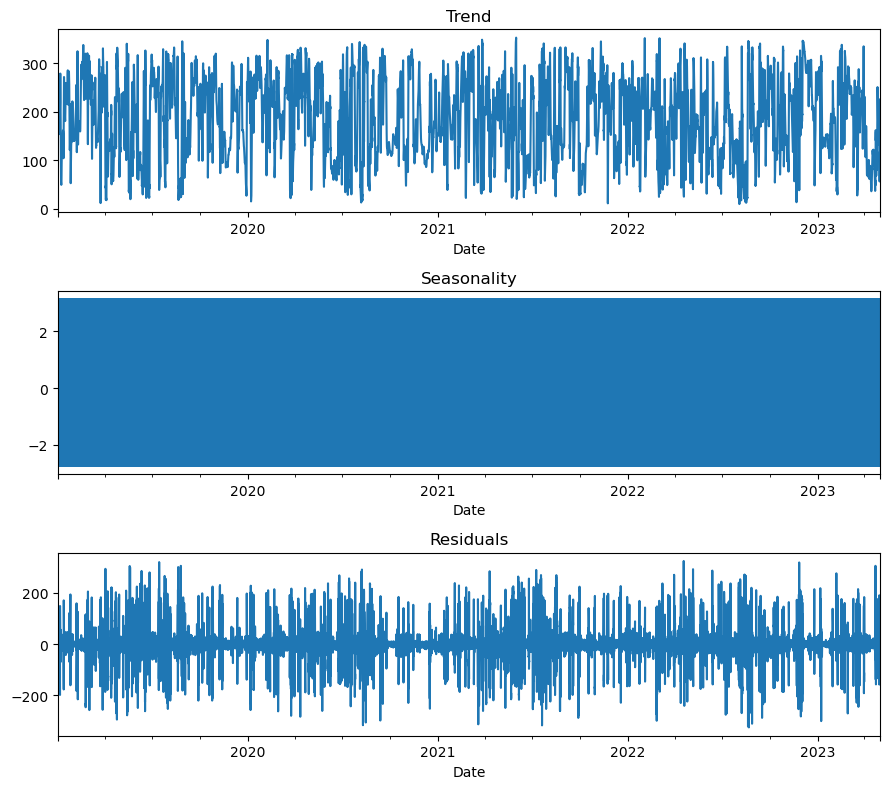

In [32]:
decompose(df['winddirection_10m'])

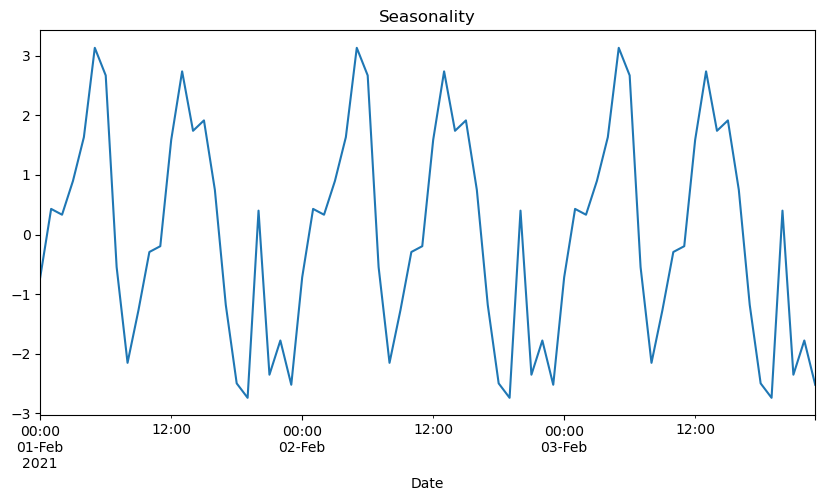

In [33]:
season(df['winddirection_10m'], '2021-02-01', '2021-02-03')

Видно, что есть определенная суточная сезонность.

count    37943.000000
mean       186.959202
std         97.652267
min          1.000000
25%        112.000000
50%        193.000000
75%        266.000000
max        360.000000
Name: winddirection_10m, dtype: float64


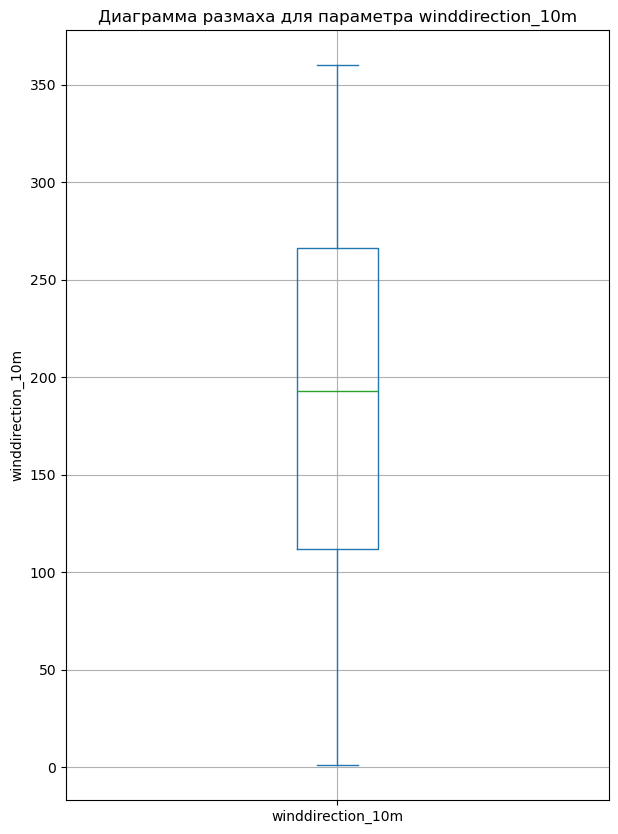

In [34]:
box(df['winddirection_10m'])

Чаще всего направление ветра составляет от 112.0° до 266.0°.

### windspeed_10m

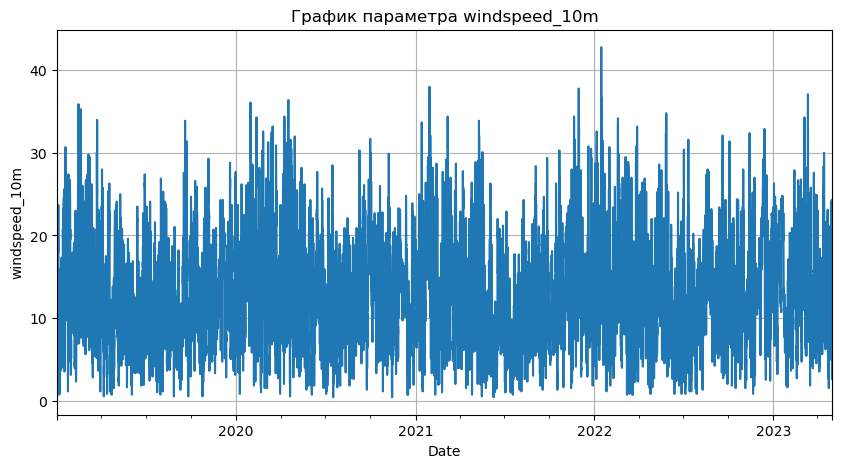

In [35]:
plot(df['windspeed_10m'])

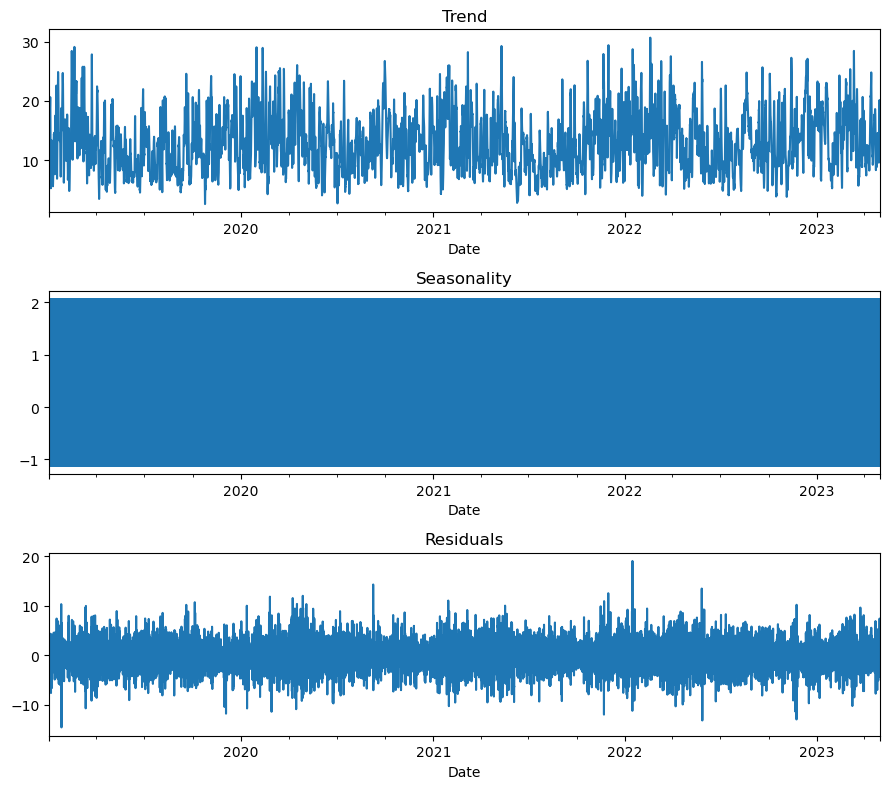

In [36]:
decompose(df['windspeed_10m'])

Видно, что есть зависимость от сезона.

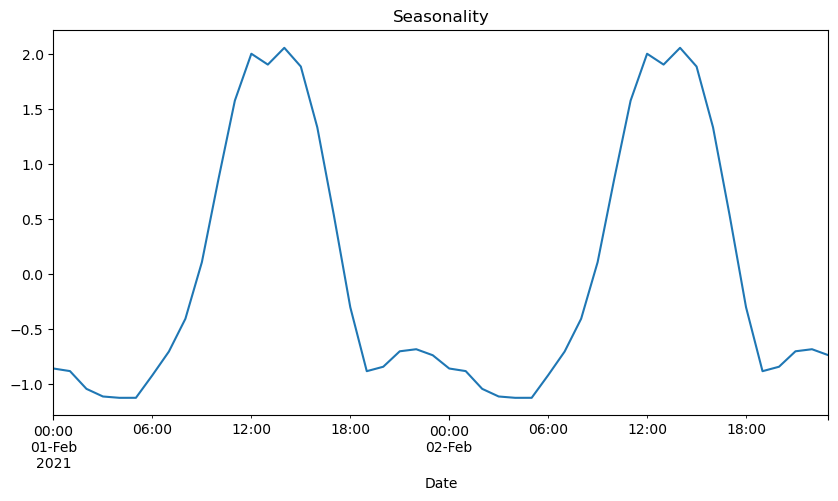

In [37]:
season(df['windspeed_10m'], '2021-02-01', '2021-02-02')

Максимум - 13:00, минимум - 19:00 - 5:00.

count    37943.000000
mean        13.138110
std          5.920226
min          0.400000
25%          8.500000
50%         12.400000
75%         17.100000
max         42.800000
Name: windspeed_10m, dtype: float64


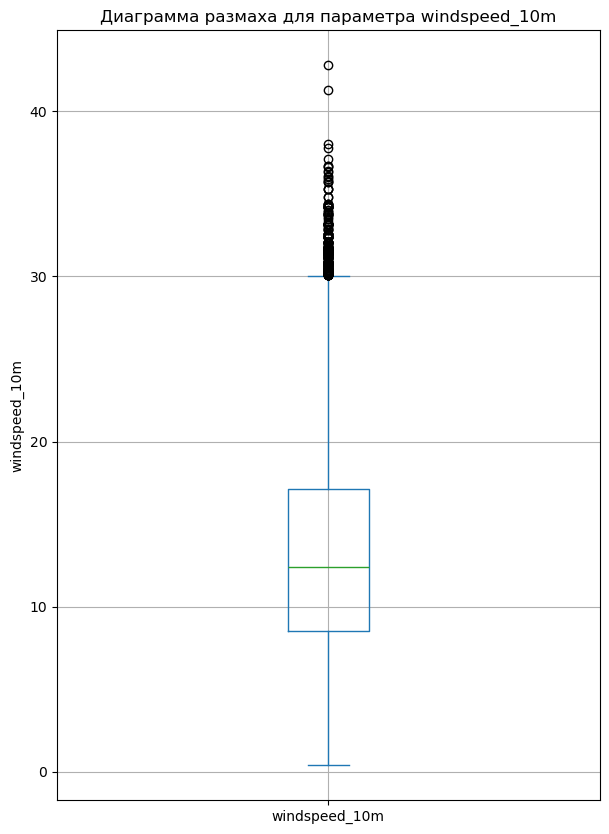

In [38]:
box(df['windspeed_10m'])

Чаще всего скорость ветра составляет от 8.5 до 17.1 м/с.

## Ресемплирование данных

По условию задачи ресемплируем данные на 2 дня.

In [39]:
print(round(df.shape[0] / 48, 3))
df = df.resample('2d').sum()

790.479


Видно, что на последнюю точку данных не наберется, ее лучше отсечь.

In [40]:
df = df[:-1]

Посмотрим, как изменился таргет и связанный с ним параметр PBR.

### power

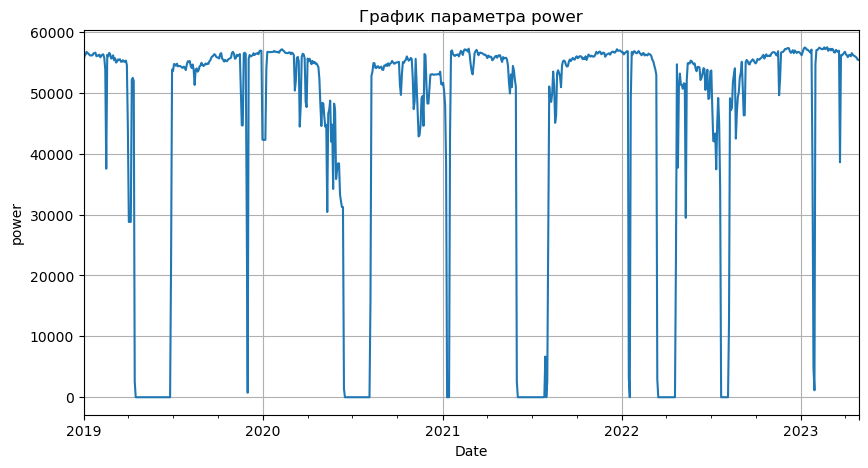

In [41]:
plot(df['power'])

Стоит отметить, что делать прогноз фактической выработки электроэнергии на неработающем блоке смысла нет, поэтому стоит отсечь остановы. Также стоит выбрать границу фильтра. Примем границу = 50000.

In [42]:
df = df.query('power > 50000')

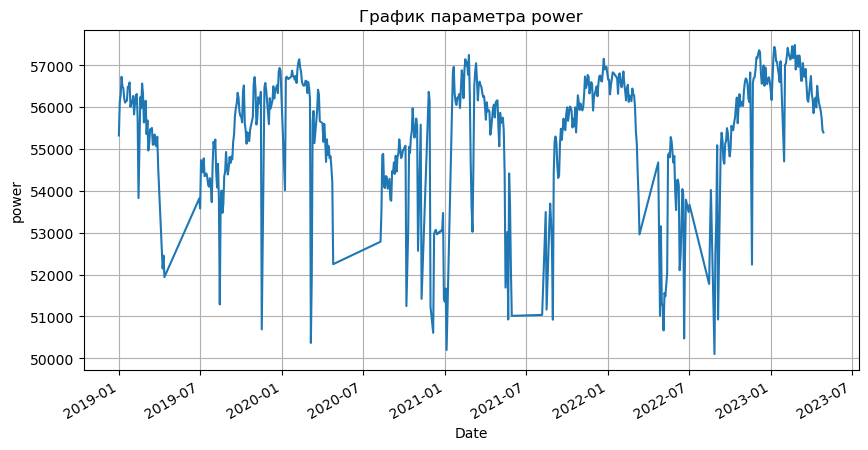

In [43]:
plot(df['power'])

count      568.000000
mean     55403.559296
std       1519.169311
min      50101.440000
25%      54733.590000
50%      55891.980000
75%      56513.580000
max      57485.880000
Name: power, dtype: float64


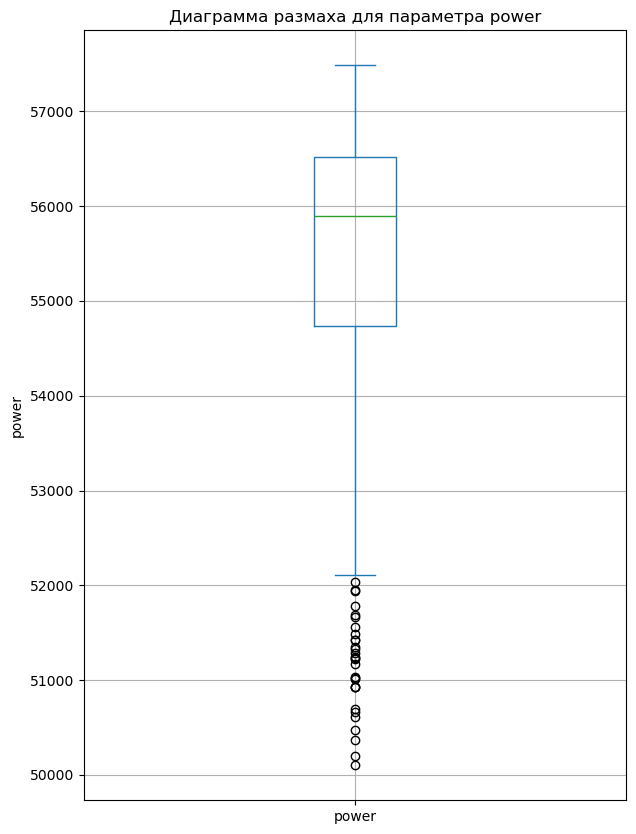

In [44]:
box(df['power'])

### PBR

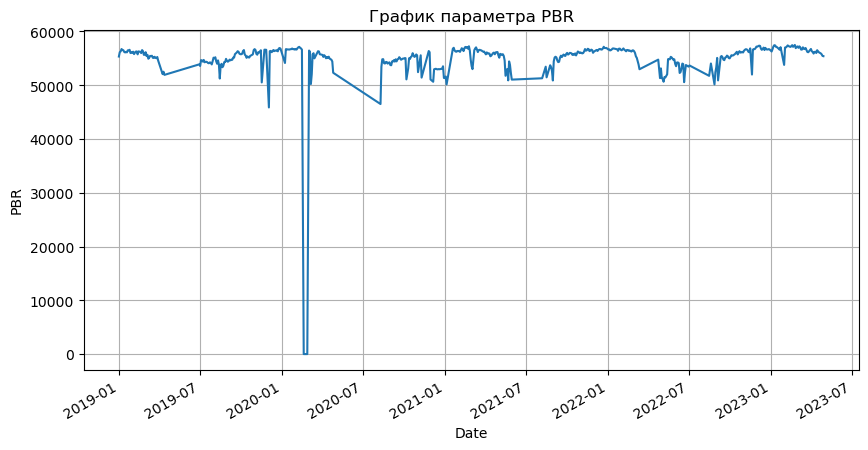

In [45]:
plot(df['PBR'])

То же сделаем и для парамтера PBR.

In [46]:
df = df.query('PBR > 50000')

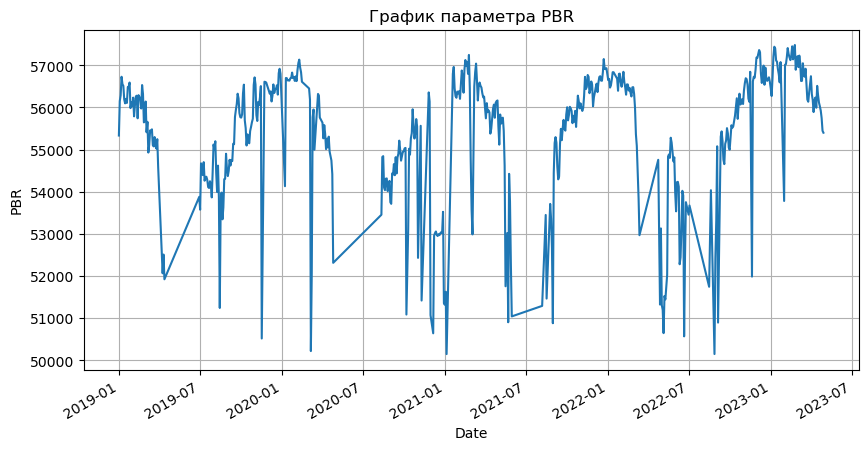

In [47]:
plot(df['PBR'])

count      559.000000
mean     55404.536150
std       1527.753382
min      50148.000000
25%      54747.500000
50%      55880.000000
75%      56530.500000
max      57480.000000
Name: PBR, dtype: float64


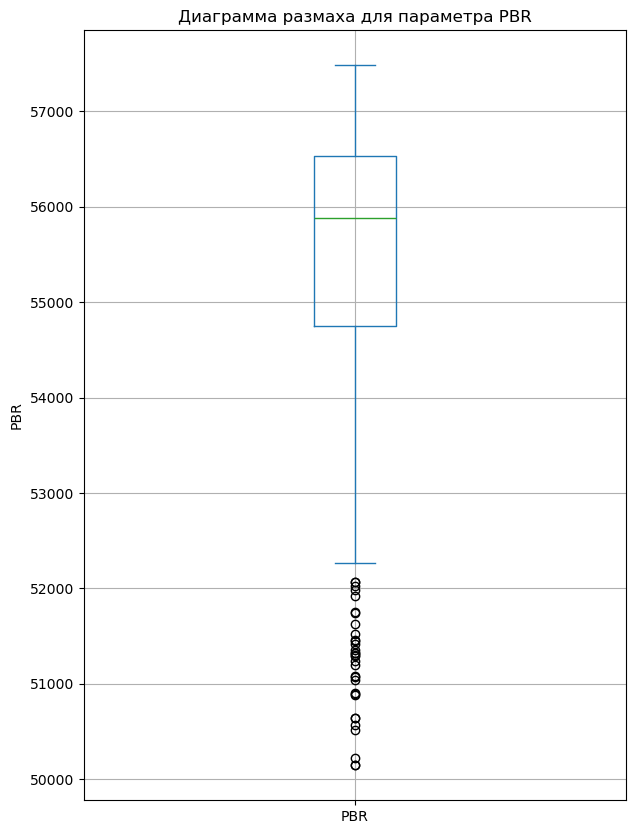

In [48]:
box(df['PBR'])

## Корреляционный анализ данных

<Axes: >

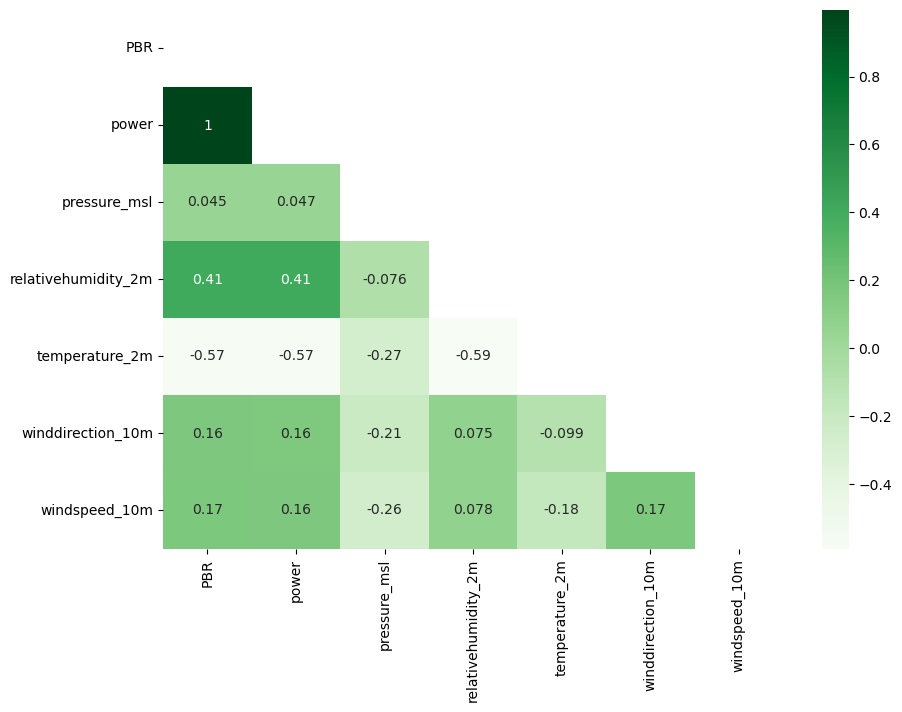

In [49]:
matrix = np.triu(df.corr())

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df.corr(), cmap="Greens", annot=True, mask=matrix)

Матрица диаграмм рассеяния:


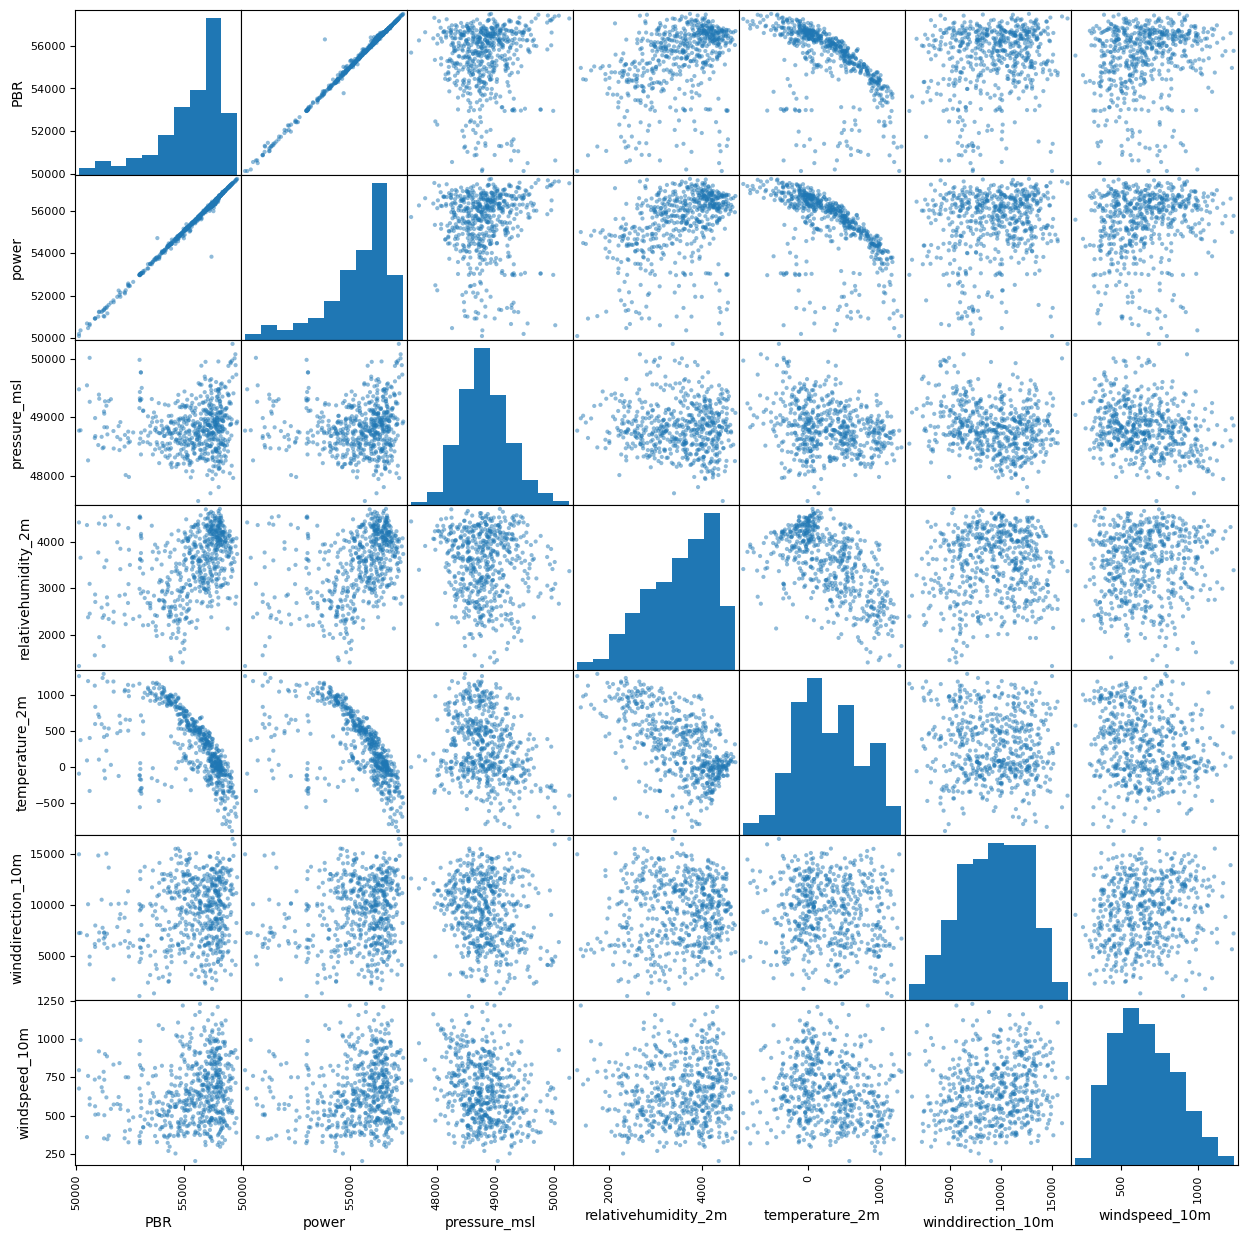

In [50]:
pd.plotting.scatter_matrix(df, figsize=(15,15))
print('Матрица диаграмм рассеяния:')

Видно, что таргет лучше всего коррелирует с параметром PBR, что опять таки неудивительно.

## Создание признаков

Очевидно, что пять последних параметров оказывают несущественное влияние на выработку электроэнергии, удалим их.

In [51]:
df = df.drop(['pressure_msl', 'relativehumidity_2m', 'temperature_2m', 'winddirection_10m', 'windspeed_10m'], axis=1)

In [52]:
def make_features(data, max_lag, rolling_mean_size):
    df_ch = df.copy()
    df_ch['year'] = data.index.year
    df_ch['month'] = data.index.month
    df_ch['day'] = data.index.day
    df_ch['day_of_week'] = data.index.dayofweek
    for f in df.columns:
        for lag in range(1, max_lag + 1):
            df_ch['lag_{}_{}'.format(f, lag)] = data[f].shift(lag)

        df_ch['rolling_mean_{}'.format(f)] = data[f].shift().rolling(rolling_mean_size).mean()
    
    return df_ch

df_ch = make_features(df, 3, 3)
df_ch = df_ch.dropna()
df_ch = df_ch.drop(['PBR'], axis=1)

## Моделирование

Для оценки моделей выберем RMSE метрику.

In [53]:
df_ch_v2 = df_ch.loc[:, (df_ch.columns != 'year') & 
                        (df_ch.columns != 'month') & 
                        (df_ch.columns != 'day') & 
                        (df_ch.columns != 'day_of_week') & 
                        (df_ch.columns != 'power')]

In [54]:
def RMSE (y_true, y_pred):

    return round(root_mean_squared_error(y_true, y_pred), 3)

rmse_scorer = make_scorer(RMSE, greater_is_better= False)

X_train, X_test, y_train, y_test = train_test_split(
    df_ch.drop(['power'], axis=1),
    df_ch['power'],
    shuffle=False,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

num_columns = df_ch_v2.columns

tssplit = TimeSeriesSplit()

Обучим 5 моделей с различными гиперпараметрами:
- LinearRegression
- DecisionTreeRegressor
- KNeighborsRegres
- RandomForestRegressor
- CatBoostRegressorsor

### LinearRegression

In [55]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [  
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

grid_search_lr = GridSearchCV(
    pipe_final,
    param_grid,
    cv=tssplit,
    scoring=rmse_scorer,
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search_lr.best_estimator_)
print ('Метрика RMSE лучшей модели на кросс-валидации:',-1 * grid_search_lr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['lag_PBR_1', 'lag_PBR_2', 'lag_PBR_3', 'rolling_mean_PBR',
       'lag_power_1', 'lag_power_2', 'lag_power_3', 'rolling_mean_power'],
      dtype='object'))])),
                ('models', LinearRegression())])
Метрика RMSE лучшей модели на кросс-валидации: 1158.9686000000002


### DecisionTreeRegressor

In [56]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

randomized_search_dtr = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tssplit,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_dtr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_dtr.best_estimator_)
print ('Метрика RMSE лучшей модели на кросс-валидации:',-1 * randomized_search_dtr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['lag_PBR_1', 'lag_PBR_2', 'lag_PBR_3', 'rolling_mean_PBR',
       'lag_power_1', 'lag_power_2', 'lag_power_3', 'rolling_mean_power'],
      dtype='object'))])),
                ('models',
                 DecisionTreeRegressor(max_depth=10, max_features=9,
                                       min_samples_leaf=19, min_samples_split=9,
                                       random_state=42))])
Метрика RMSE лучшей модели на кросс-валидации: 1098.3755999999998


### KNeighborsRegressor

In [57]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsRegressor())
])

param_grid = [
    { 
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 30),
        'models__algorithm': ['ball_tree', 'kd_tree'],
        'models__leaf_size': range(2, 60),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

randomized_search_knr = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tssplit,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_knr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_knr.best_estimator_)
print ('Метрика RMSE лучшей модели на кросс-валидации:',-1 * randomized_search_knr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['lag_PBR_1', 'lag_PBR_2', 'lag_PBR_3', 'rolling_mean_PBR',
       'lag_power_1', 'lag_power_2', 'lag_power_3', 'rolling_mean_power'],
      dtype='object'))])),
                ('models',
                 KNeighborsRegressor(algorithm='ball_tree', leaf_size=48,
                                     n_neighbors=11))])
Метрика RMSE лучшей модели на кросс-валидации: 1083.257


### RandomForestRegressor

In [58]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestRegressor())
])

param_grid = [
    { 
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 200),  
        'models__max_depth': range(2, 40),       
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

randomized_search_rfr = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tssplit,
    random_state=RANDOM_STATE,
    scoring=rmse_scorer,
    n_jobs=-1
)

randomized_search_rfr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_rfr.best_estimator_)
print ('Метрика RMSE лучшей модели на кросс-валидации:',-1 * randomized_search_rfr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  Index(['lag_PBR_1', 'lag_PBR_2', 'lag_PBR_3', 'rolling_mean_PBR',
       'lag_power_1', 'lag_power_2', 'lag_power_3', 'rolling_mean_power'],
      dtype='object'))])),
                ('models',
                 RandomForestRegressor(max_depth=16, n_estimators=133,
                                       random_state=42))])
Метрика RMSE лучшей модели на кросс-валидации: 1094.7376


### CatBoostRegressor

In [59]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor())
])

param_grid = [
    { 
        'models': [CatBoostRegressor(loss_function='RMSE', random_state=RANDOM_STATE, verbose=0)],
        'models__iterations': range(100, 500),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

randomized_search_cbr = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tssplit,
    random_state=RANDOM_STATE,
    scoring=rmse_scorer,
    n_jobs=-1
)

randomized_search_cbr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_cbr.best_estimator_)
print ('Метрика RMSE лучшей модели на кросс-валидации:',-1 * randomized_search_cbr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  Index(['lag_PBR_1', 'lag_PBR_2', 'lag_PBR_3', 'rolling_mean_PBR',
       'lag_power_1', 'lag_power_2', 'lag_power_3', 'rolling_mean_power'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x000002062AE28990>)])
Метрика RMSE лучшей модели на кросс-валидации: 1193.6894


## Анализ результатов

In [60]:
print ('Метрика RMSE модели LinearRegression на кросс-валидации:', round(-1 * grid_search_lr.best_score_, 3))
print ('Метрика RMSE модели DecisionTreeRegressor на кросс-валидации:', round(-1 * randomized_search_dtr.best_score_, 3))
print ('Метрика RMSE модели KNeighborsRegressor на кросс-валидации:', round(-1 * randomized_search_knr.best_score_, 3))
print ('Метрика RMSE модели RandomForestRegressor на кросс-валидации:', round(-1 * randomized_search_rfr.best_score_, 3))
print ('Метрика RMSE модели CatBoostRegressor на кросс-валидации:', round(-1 * randomized_search_cbr.best_score_, 3))

Метрика RMSE модели LinearRegression на кросс-валидации: 1158.969
Метрика RMSE модели DecisionTreeRegressor на кросс-валидации: 1098.376
Метрика RMSE модели KNeighborsRegressor на кросс-валидации: 1083.257
Метрика RMSE модели RandomForestRegressor на кросс-валидации: 1094.738
Метрика RMSE модели CatBoostRegressor на кросс-валидации: 1193.689


Лучший результат показала  модель **KNeighborsRegressor** с такими гиперпараметрами:

In [61]:
print(randomized_search_knr.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['lag_PBR_1', 'lag_PBR_2', 'lag_PBR_3', 'rolling_mean_PBR',
       'lag_power_1', 'lag_power_2', 'lag_power_3', 'rolling_mean_power'],
      dtype='object'))])),
                ('models',
                 KNeighborsRegressor(algorithm='ball_tree', leaf_size=48,
                                     n_neighbors=11))])


## Тестирование

In [62]:
model = randomized_search_rfr.best_estimator_
y_pred = model.predict(X_test)
print('RMSE модели KNeighborsRegressor на тестовой выборке =', RMSE(y_test, y_pred))

RMSE модели KNeighborsRegressor на тестовой выборке = 837.064


In [63]:
y_pred = pd.DataFrame(data=y_pred)
y_pred['timestamp_hour_end'] = y_test.index
y_pred = y_pred.set_index('timestamp_hour_end')

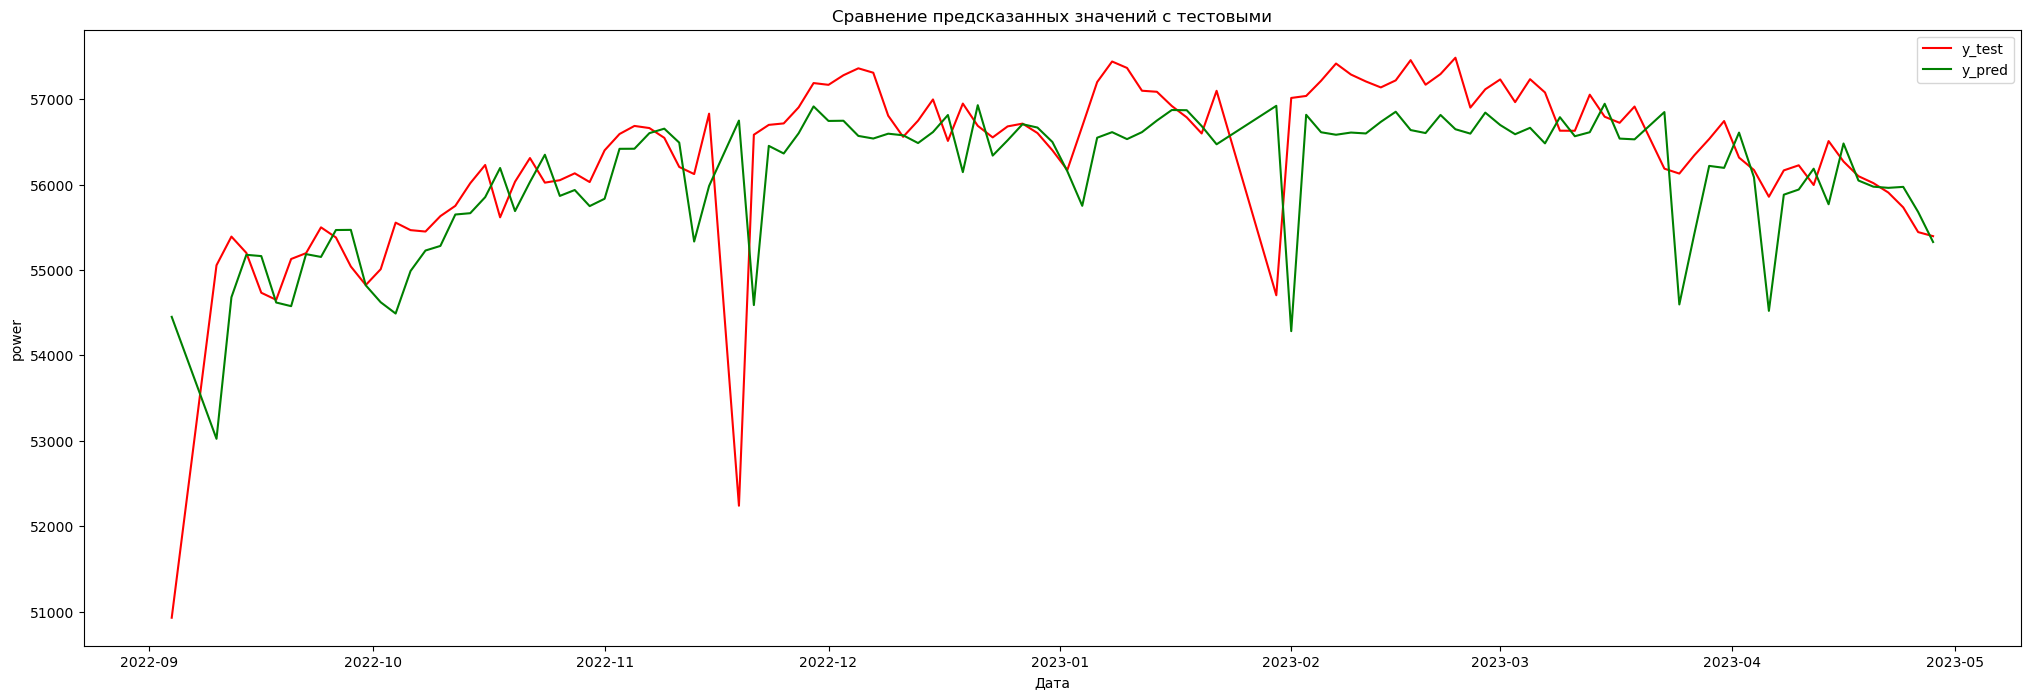

In [64]:
plt.figure(figsize=(25,8))

plt.plot(y_test, color='r', label='y_test')
plt.plot(y_pred, color='g', label='y_pred')

plt.title('Сравнение предсказанных значений с тестовыми')
plt.xlabel('Дата')
plt.ylabel('power')

plt.legend()